<a href="https://colab.research.google.com/github/woosukji/DACON_LGUserClassification/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'dacon/'

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd drive/My\ Drive/$FOLDERNAME

import tensorflow as tf
import tensorflow.keras as k
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm
import lightgbm as lgb
from sklearn.metrics import *
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings(action='ignore')

PATH = './data/'

train_err  = pd.read_csv(PATH+'train_err_data.csv', thousands=',')
train_qual  = pd.read_csv(PATH+'train_quality_data.csv', thousands=',')
train_prob  = pd.read_csv(PATH+'train_problem_data.csv', thousands=',')
test_err  = pd.read_csv(PATH+'test_err_data.csv', thousands=',')
test_qual = pd.read_csv(PATH+'test_quality_data.csv', thousands=',')

li = ['quality_5', 'quality_7', 'quality_8', 'quality_9', 'quality_10',]
train_qual[li] = train_qual[li].apply(pd.to_numeric)
test_qual[li] = test_qual[li].apply(pd.to_numeric)

def mk_col_datetime(df) :
  df['datetime'] = pd.to_datetime(df.time, format = '%Y%m%d%H%M%S')

mk_col_datetime(train_err)
mk_col_datetime(train_qual)
mk_col_datetime(train_prob)
mk_col_datetime(test_err)
mk_col_datetime(test_qual)

train_err = train_err[train_err.datetime.dt.month == 11]
train_qual = train_qual[train_qual.datetime.dt.month == 11]
test_err = test_err[test_err.datetime.dt.month == 11]
test_qual = test_qual[test_qual.datetime.dt.month == 11]

print('train err shape : ', train_err.shape)
print('train quality shape : ', train_qual.shape)
print('train problem shape : ', train_prob.shape)
print('test err shape : ', test_err.shape)
print('test quality shape : ', test_qual.shape)

Mounted at /content/drive
/content/drive/My Drive/dacon
train err shape :  (16554577, 7)
train quality shape :  (828408, 17)
train problem shape :  (5429, 3)
test err shape :  (16532572, 7)
test quality shape :  (747840, 17)


In [ ]:
# 범위 넘어가는 날짜는 필요없을듯

test_err[test_err.datetime >= pd.to_datetime('201201', format='%y%m%d')]

,user_id,time,model_nm,fwver,errtype,errcode,datetime
103737,30102,20201203232300,model_3,05.15.2138,14,1,2020-12-03 23:23:00
103738,30102,20201203232411,model_3,05.15.2138,6,1,2020-12-03 23:24:11
103739,30102,20201203232530,model_3,05.15.2138,7,1,2020-12-03 23:25:30
250038,30263,20201201095258,model_2,04.33.1261,14,13,2020-12-01 09:52:58
250039,30263,20201201095258,model_2,04.33.1261,7,14,2020-12-01 09:52:58
...,...,...,...,...,...,...,...
15535212,44100,20201201000106,model_0,04.22.1778,14,14,2020-12-01 00:01:06
15535213,44100,20201201000112,model_0,04.22.1778,6,14,2020-12-01 00:01:12
16007374,44543,20201201085022,model_0,04.22.1778,14,13,2020-12-01 08:50:22
16007375,44543,20201201085022,model_0,04.22.1778,6,14,2020-12-01 08:50:22


##  Q1. `err`, `qual`, `prob` 각각에서 `datetime`의 counts를 일별, 요일별, 시간별로 보자.

### Q1-1. `err`

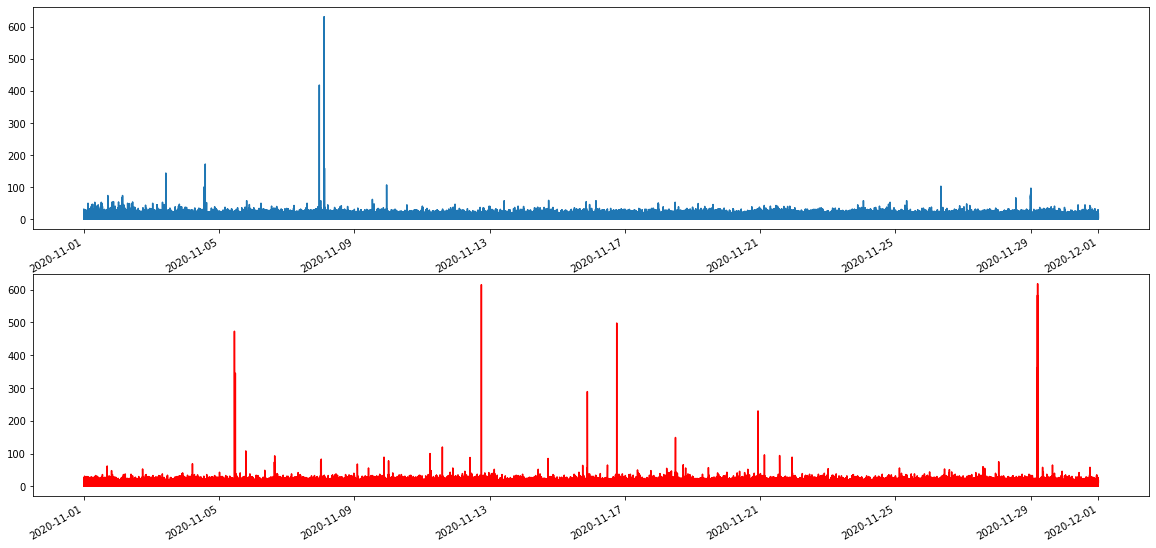

In [ ]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
train_err['datetime'].value_counts(sort = False).plot(kind = 'line')
plt.subplot(2, 1, 2)
test_err['datetime'].value_counts(sort = False).plot(kind = 'line', color='r')

(737730.0, 737731.0)

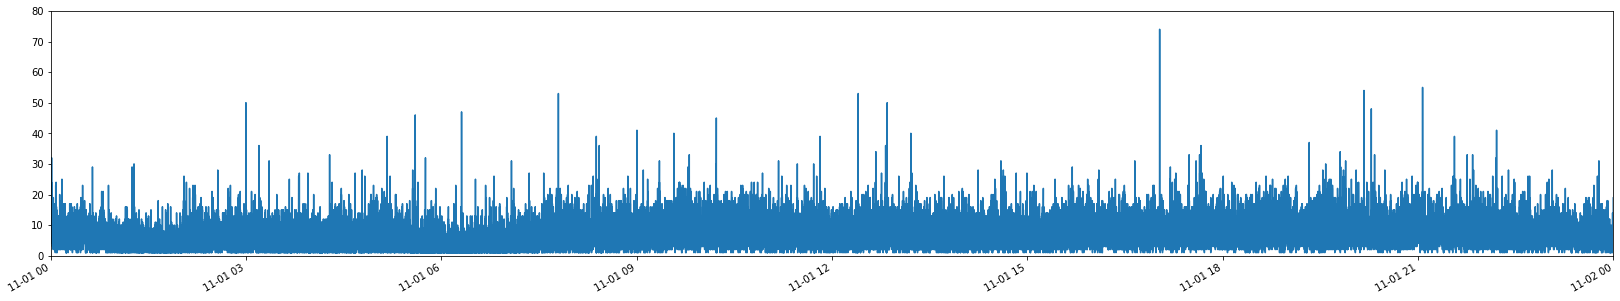

In [ ]:
# 하루 단위로 자세히 봐도 특별한 변동은 없다

plt.figure(figsize=(28,5))
train_err['datetime'].value_counts(sort = False).plot(kind = 'line')
plt.ylim(0, 80)
plt.xlim(pd.to_datetime('2020-11-01'), pd.to_datetime('2020-11-02'))

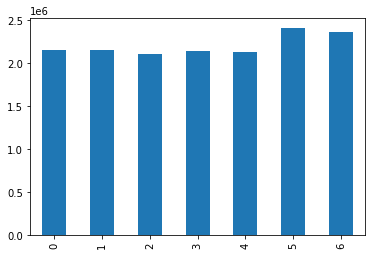

In [ ]:
# 요일별로 train_err의 합산. 큰 차이는 없어보임. test_err도 비슷할것
# 주말이 좀 더 많긴 한데, 아무래도 쉬는 날 전자제품을 많이 사용해서일까?

(train_err.datetime[ train_err.datetime.dt.day <= 28 ]
  .dt.weekday
  .value_counts(sort=False)
  .plot(kind='bar'))

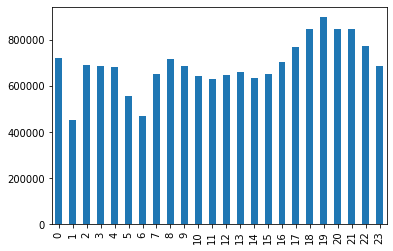

In [ ]:
# 시간별로 train_err의 합산

(train_err.datetime
  .dt.hour
  .value_counts(sort=False)
  .plot(kind='bar'))

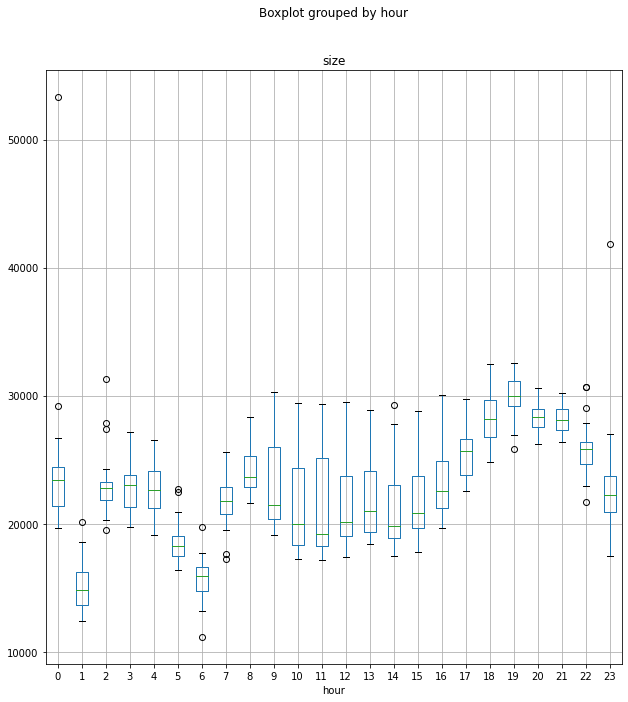

In [ ]:
# 약간 패턴이 보이나? outlier 때문인 것 같은데... 라고 생각했지만 아닌 것 같다

train_err['day'] = train_err.datetime.dt.day
train_err['hour'] = train_err.datetime.dt.hour
(train_err.groupby(['day', 'hour'], as_index=False)
  .size()
  .boxplot('size', 'hour', figsize=(10, 11)))

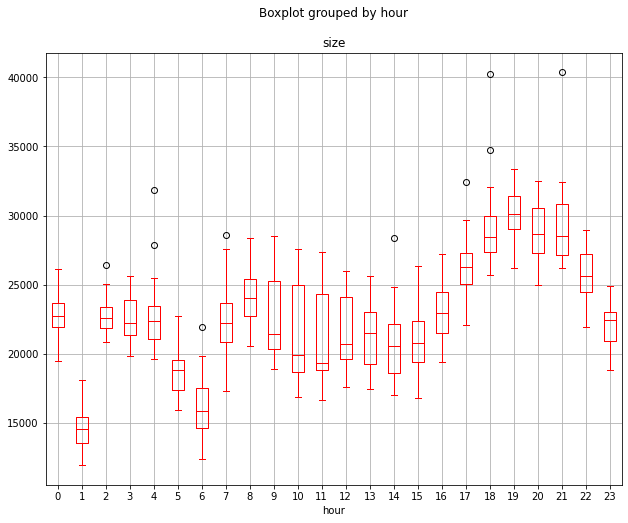

In [ ]:
# test_err 에서도 동일한 패턴!

test_err['day'] = test_err.datetime.dt.day
test_err['hour'] = test_err.datetime.dt.hour
(test_err.groupby(['day', 'hour'], as_index=False)
  .size()
  .boxplot('size', 'hour', figsize=(10, 8), color='r'))

### Q1-2. `qual`

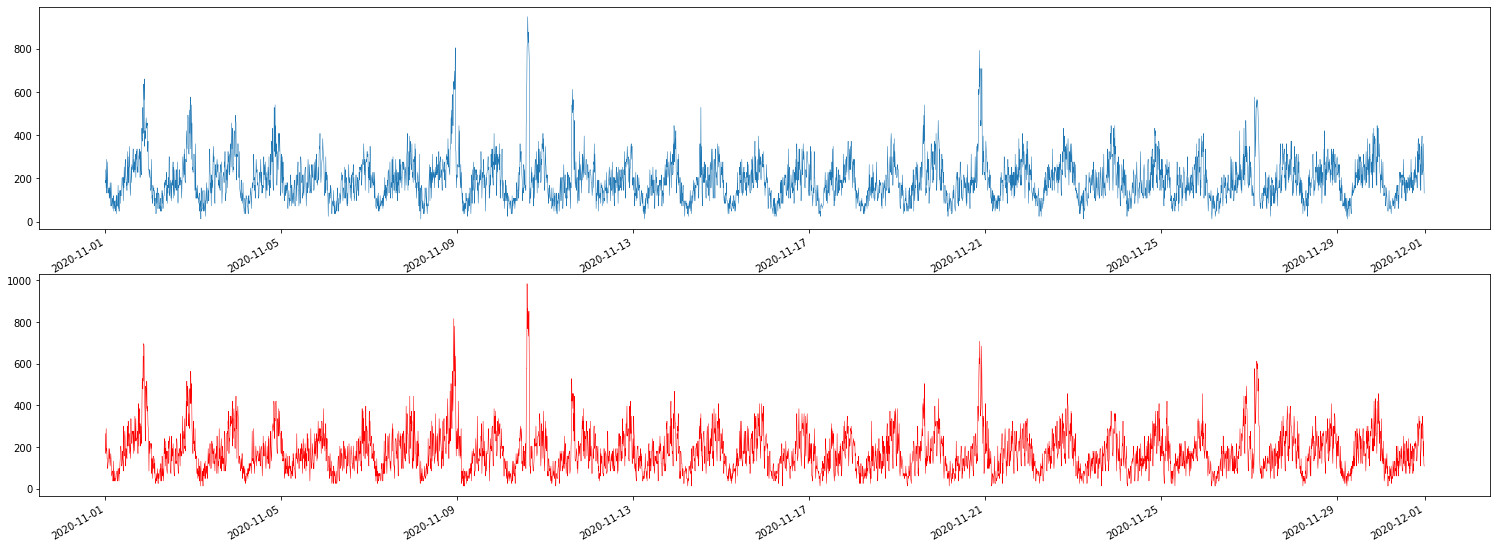

In [ ]:
# 시간별로 아주 확연한 차이
# err 와 달리, 피크 발생 시점이 겹침. 개인적인 문제가 아니라, 전체 model 또는 특정 시기의 문제라는 뜻.

plt.figure(figsize=(26,10))
plt.subplot(2, 1, 1)
train_qual['datetime'].value_counts(sort = False).plot(kind = 'line', lw=0.5, label='train')
plt.subplot(2, 1, 2)
test_qual['datetime'].value_counts(sort = False).plot(kind = 'line', lw=0.5, color='r', label='test')

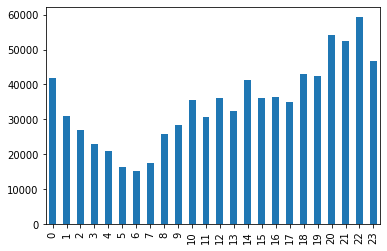

In [ ]:
(train_qual.datetime
  .dt.hour
  .value_counts(sort=False)
  .plot(kind='bar'))

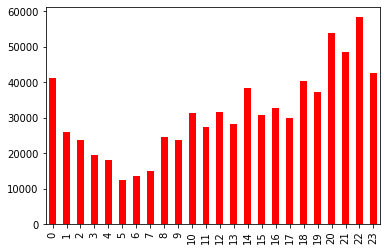

In [ ]:
(test_qual.datetime
  .dt.hour
  .value_counts(sort=False)
  .plot(kind='bar', color='r'))

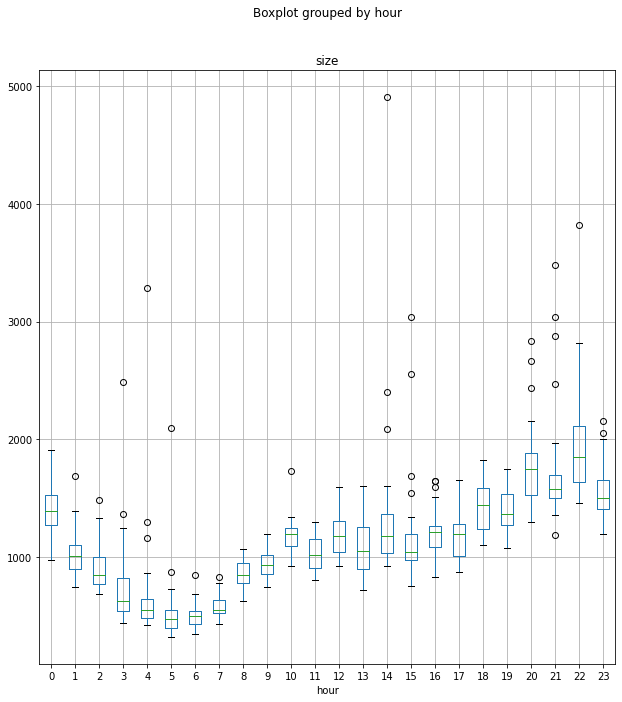

In [ ]:
# 각 날짜별로도 찍어보자.. 어라 생각보다 차이가 작네

train_qual['day'] = train_qual.datetime.dt.day
train_qual['hour'] = train_qual.datetime.dt.hour
(train_qual.groupby(['day', 'hour'], as_index=False)
  .size()
  .boxplot('size', 'hour', figsize=(10, 11)))

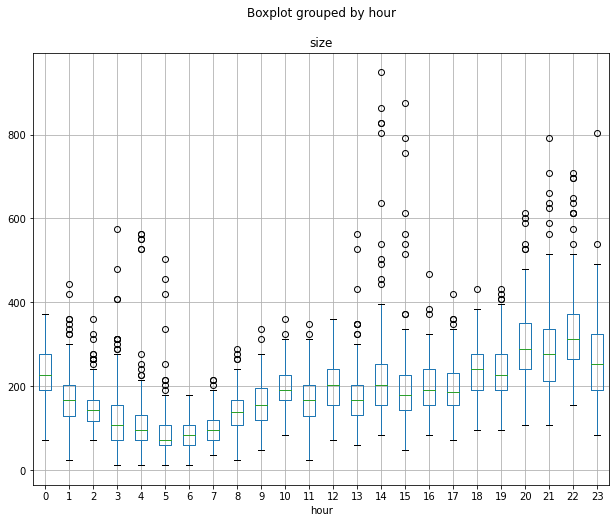

In [ ]:
#10분 단위로 보자.. 어라랏 더욱 차이가 없네

train_qual['ten_minutes'] = np.floor(train_qual.datetime.dt.minute / 10)
(train_qual.groupby(['day', 'hour', 'ten_minutes'], as_index=False)
  .size()
  .boxplot('size', 'hour', figsize = (10,8)))

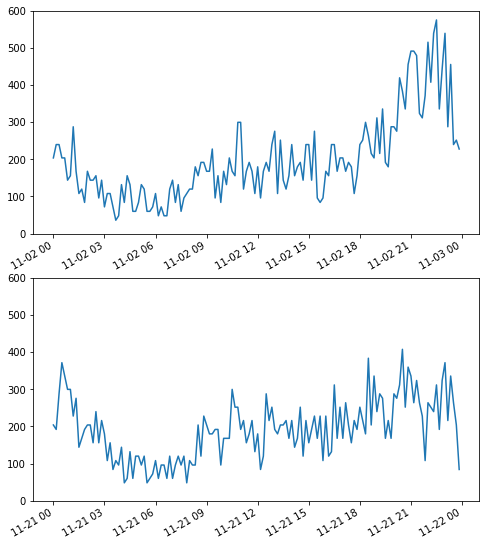

In [ ]:
# 사실 뜯어보니까 엄청 확연하진 않은듯..

plt.figure(figsize=(8,10))
plt.subplot(2, 1, 1)
train_qual['datetime'][train_qual.datetime.dt.day == 2].value_counts(sort=False).plot(kind='line', ylim=(0,600), label='day 1')
plt.subplot(2, 1, 2)
train_qual['datetime'][train_qual.datetime.dt.day == 21].value_counts(sort=False).plot(kind='line', ylim=(0,600), label='day 29')

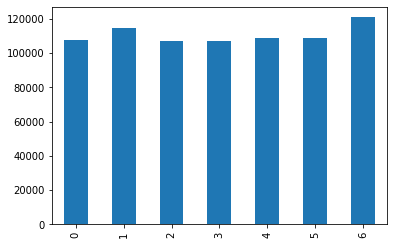

In [ ]:
# 요일별로는? 음 역시.

(train_qual.datetime[ train_qual.datetime.dt.day <= 28 ]
  .dt.weekday
  .value_counts(sort=False)
  .plot(kind='bar'))

### Q1-3. `prob`

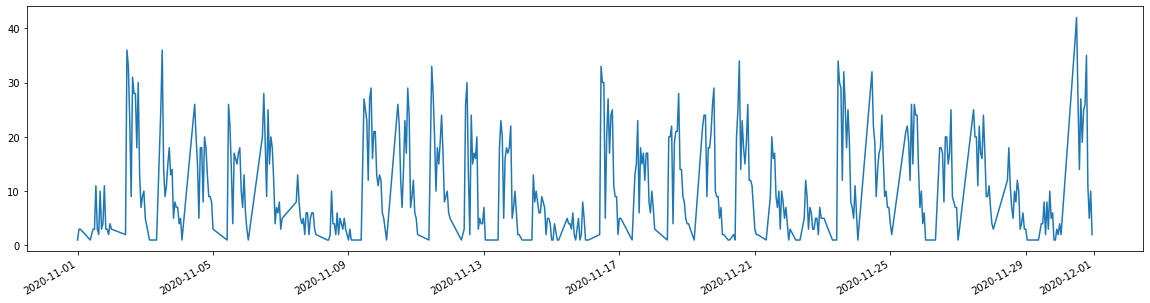

In [ ]:
plt.figure(figsize=(20,5))
train_prob.datetime.value_counts(sort=False).plot(kind='line')

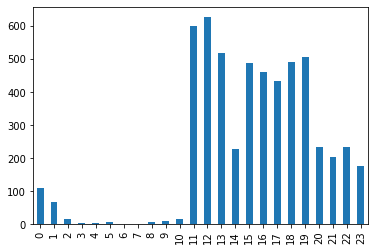

In [ ]:
(train_prob.datetime
  .dt.hour
  .value_counts()
  .sort_index()
  .plot(kind='bar'))

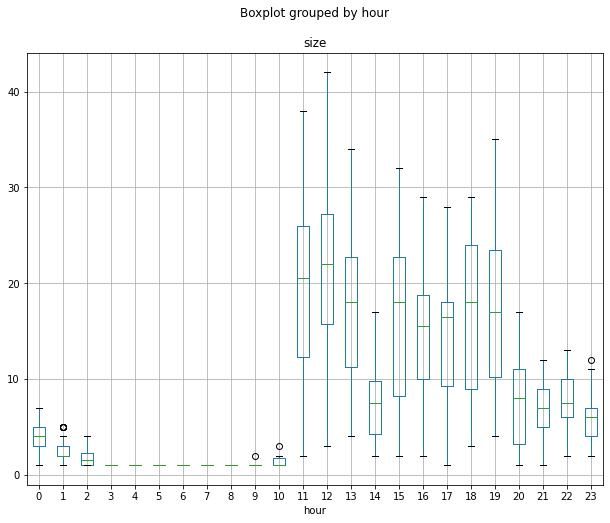

In [ ]:
train_prob['day'] = train_prob.datetime.dt.day
train_prob['hour'] = train_prob.datetime.dt.hour
(train_prob.groupby(['day', 'hour'], as_index=False)
  .size()
  .boxplot('size', 'hour', figsize=(10, 8)))

#### 질문
예상대로, `prob`은 고객센터 운영 시간대에만 확연하게 몰리고, 이외에는(특히 새벽시간대) 거의 없다.

그런데, 몇몇 있는 특이 시간대 또는 주말 데이터는 어떻게 만들어졌을까??
- 가설 1. 모바일 또는 자동화 시스템으로 접수받은 것이다. -> 고객센터 운영방식 확인해야 함. 이때 `model_nm`이 몰린다면 이 `model`이 핸드폰일 것 같다.
- 가설 2. 시간을 치기 귀찮아서 아무렇게나 쳤다. -> 시간만 있고 분, 초는 0일 것. 특히 00시가 이런 케이스가 많을 것.

또, 2시는 왜 갑자기 적을까?
- 가설 1. 고객센터 점심시간대. -> 고객센터 운영방식 확인해야 함.

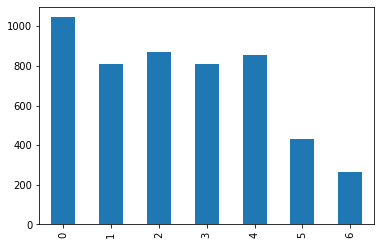

In [ ]:
(train_prob[train_prob.datetime.dt.day <= 28]
  .datetime
  .dt.weekday
  .value_counts()
  .sort_index()
  .plot(kind='bar'))

## Q2. `qual_n` 중 object 들은 어떻게 생겼을까?

In [ ]:
train_qual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 828408 entries, 0 to 828623
Data columns (total 20 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   time         828408 non-null  int64         
 1   user_id      828408 non-null  int64         
 2   fwver        788340 non-null  object        
 3   quality_0    683988 non-null  float64       
 4   quality_1    828408 non-null  int64         
 5   quality_2    788307 non-null  float64       
 6   quality_3    828408 non-null  int64         
 7   quality_4    828408 non-null  int64         
 8   quality_5    828388 non-null  object        
 9   quality_6    828408 non-null  int64         
 10  quality_7    828408 non-null  object        
 11  quality_8    828408 non-null  object        
 12  quality_9    828408 non-null  object        
 13  quality_10   828408 non-null  object        
 14  quality_11   828408 non-null  int64         
 15  quality_12   828408 non-null  int6

In [ ]:
train_err.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16554577 entries, 0 to 16554662
Data columns (total 7 columns):
 #   Column    Dtype         
---  ------    -----         
 0   user_id   int64         
 1   time      int64         
 2   model_nm  object        
 3   fwver     object        
 4   errtype   int64         
 5   errcode   object        
 6   datetime  datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 1010.4+ MB


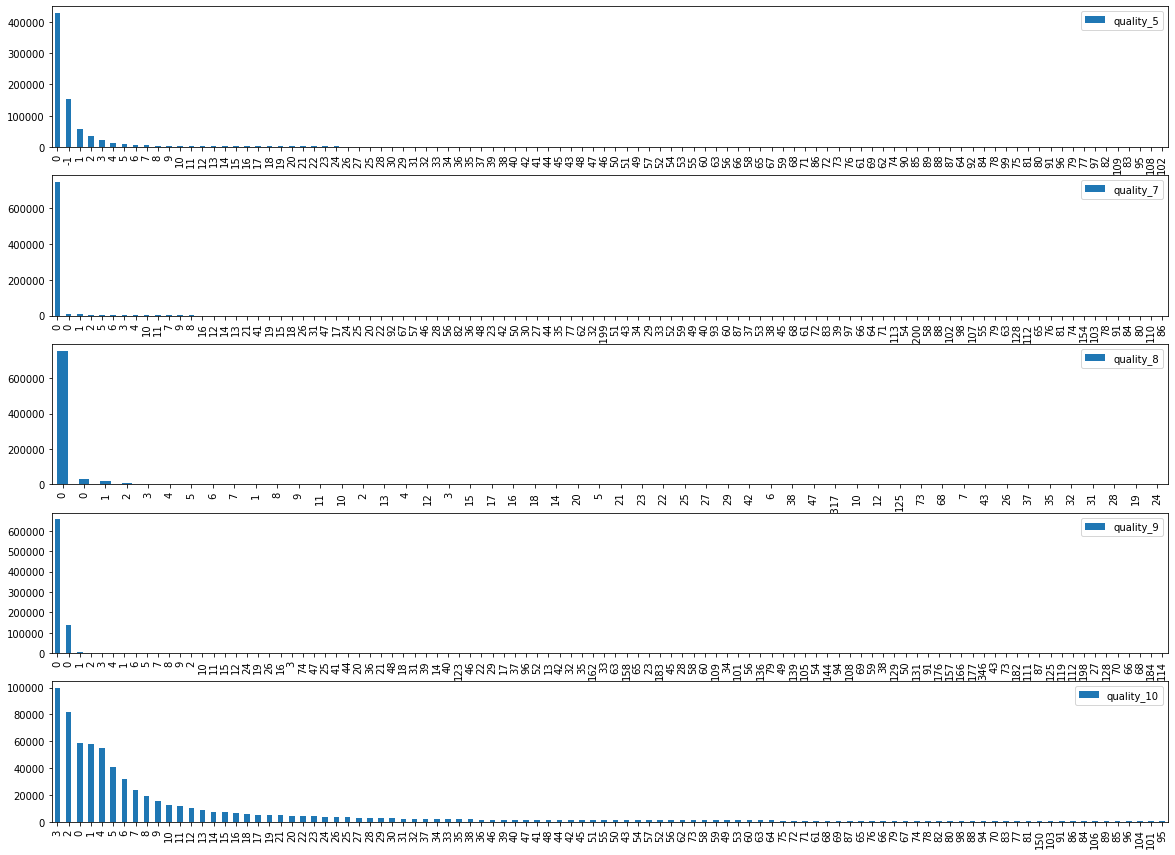

In [ ]:
# 왜 다 숫자같지??

# 이렇게는 하지 말자... subplot 싸랑해요
#fig, axes = plt.subplots(5, 1)
#for ax, qual in zip(axes, ['quality_5', 'quality_7', 'quality_8', 'quality_9', 'quality_10']) :
#  count = train_qual[qual].value_counts()[:100]
#  ax.bar( [str(i) for i in count.index], count  )
# train_qual.quality_5.value_counts()[:100].plot(kind='bar')

plt.figure(figsize=(20, 15))
for i, qual in enumerate(['quality_5', 'quality_7', 'quality_8', 'quality_9', 'quality_10']) :
  plt.subplot(5, 1, i+1)
  train_qual[qual].value_counts()[:100].plot(kind='bar', label=qual)
  plt.legend()

In [ ]:
# 문자 나와라
import re

# qual_5의 정체는 -1 이었습니다~!

display(train_qual.quality_5[train_qual.quality_5.str.match('^\D', na=True)])
print('')
display(train_qual.quality_5[train_qual.quality_5.str.match('^\D', na=True) & (train_qual.quality_5 != '-1')])

72        -1
73        -1
130       -1
131       -1
158       -1
          ..
828591    -1
828608    -1
828609    -1
828610    -1
828611    -1
Name: quality_5, Length: 153345, dtype: object

58907     NaN
150490    NaN
150491    NaN
150502    NaN
150503    NaN
150527    NaN
150538    NaN
150539    NaN
209696    NaN
209697    NaN
213467    NaN
213479    NaN
213491    NaN
259931    NaN
277103    NaN
360071    NaN
451774    NaN
451775    NaN
595427    NaN
771515    NaN
Name: quality_5, dtype: object

In [ ]:
# qual_7의 정체는 숫자였습니다~!

display(train_qual.quality_7[train_qual.quality_7.str.match('^\D', na=True)])
print('')
print(list(train_qual.quality_7[train_qual.quality_7.str.match('^\D', na=True) & (train_qual.quality_7 != 0)]))

819200    0
819201    0
819202    0
819203    0
819204    0
         ..
828619    0
828620    0
828621    0
828622    0
828623    0
Name: quality_7, Length: 9424, dtype: object


[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 744, 744, 744, 744, 744, 744, 744, 744, 744, 744, 744, 744, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16

In [ ]:
# 나머지도 모두 숫자였다...

print(list(train_qual.quality_8[train_qual.quality_8.str.match('^\D', na=True) & (train_qual.quality_8 != 0)]))
print(list(train_qual.quality_9[train_qual.quality_9.str.match('^\D', na=True) & (train_qual.quality_9 != 0)]))
print(list(train_qual.quality_10[train_qual.quality_10.str.match('^\D', na=True)]))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

## Q3. 결측치들은 어떻게 생겼을까?

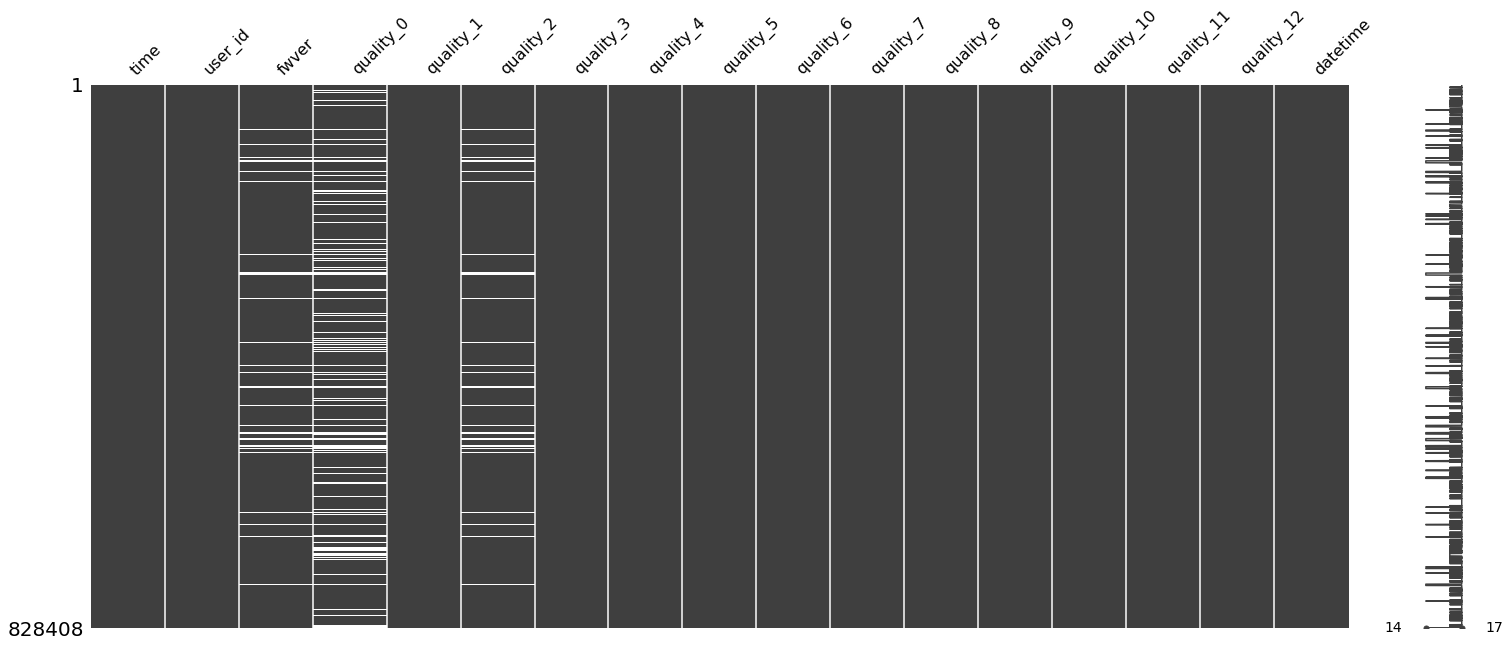

In [ ]:
import missingno as mn

mn.matrix(train_qual)

In [ ]:
train_qual[train_qual.quality_0.isnull()]

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12,datetime
3852,20201104022000,10080,03.11.1149,NaN,-1,-1.0,0,0,-1,-1,0,0,3,1,-1,0,2020-11-04 02:20:00
3853,20201104022000,10080,03.11.1149,NaN,-1,-1.0,0,0,-1,-1,0,0,3,1,-1,0,2020-11-04 02:20:00
3854,20201104022000,10080,03.11.1149,NaN,0,2.0,0,0,1,0,0,0,3,1,0,0,2020-11-04 02:20:00
3855,20201104022000,10080,03.11.1149,NaN,0,1.0,0,0,0,0,0,0,3,1,0,0,2020-11-04 02:20:00
3856,20201104022000,10080,03.11.1149,NaN,0,0.0,0,0,0,0,0,0,3,1,0,0,2020-11-04 02:20:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828511,20201121113000,24990,03.11.1167,NaN,-1,-1.0,0,0,-1,-1,0,0,0,1,-1,0,2020-11-21 11:30:00
828512,20201121113000,24990,03.11.1167,NaN,-1,-1.0,0,0,-1,-1,0,0,0,1,-1,0,2020-11-21 11:30:00
828513,20201121113000,24990,03.11.1167,NaN,0,0.0,0,0,0,0,0,0,0,1,0,0,2020-11-21 11:30:00
828514,20201121113000,24990,03.11.1167,NaN,0,0.0,0,0,0,0,0,0,0,1,0,0,2020-11-21 11:30:00


In [ ]:
# fwver의 문제?

train_qual[train_qual.quality_0.isnull()].fwver.value_counts(dropna=False)

03.11.1167    104148
NaN            40068
03.11.1149       204
Name: fwver, dtype: int64

In [ ]:
# 정확히 같음. quality_0 의 nan은 모두 fwver 때문이었다.

train_qual.fwver[train_qual.fwver.isin(['03.11.1167', '03.11.1149']) | train_qual.fwver.isnull()].value_counts(dropna=False)

03.11.1167    104148
NaN            40068
03.11.1149       204
Name: fwver, dtype: int64

In [ ]:
# quality_2 도 같은 결과. 모두 quality_0 에 포함된다!
# 아무튼 quality_0, 2 는 fwver과 관련이 있을 것

display(train_qual.fwver[train_qual.quality_2.isnull()].value_counts(dropna=False))
print('='*80)
display(train_qual.fwver[train_qual.fwver == '04.16.3553'].value_counts())

NaN           40068
04.16.3553       33
Name: fwver, dtype: int64

04.16.3553    111936
Name: fwver, dtype: int64

In [ ]:
# test 로도 해보자

display(test_qual[test_qual.quality_0.isnull()].fwver.value_counts(dropna=False))
print('='*80)
display(test_qual.fwver[test_qual.fwver.isin(['03.11.1167', '03.11.1149']) | test_qual.fwver.isnull()].value_counts(dropna=False))

03.11.1167    84240
NaN           21156
03.11.1149     1188
Name: fwver, dtype: int64

03.11.1167    84240
NaN           22764
03.11.1149     1188
Name: fwver, dtype: int64

In [ ]:
# 거의 비슷한 결과. quality_2 는 fwver 이 nan 인 것과 관련 있는건가?

display(test_qual[test_qual.quality_2.isnull()].fwver.value_counts(dropna=False))
print('='*80)
display(test_qual.fwver[test_qual.fwver.isin(['04.16.3553', '05.15.2138'])].value_counts(dropna=False))

NaN           21084
04.16.3553       20
05.15.2138       11
Name: fwver, dtype: int64

05.15.2138    142656
04.16.3553    109032
Name: fwver, dtype: int64

## Q4. `err` 이 많은 사람 3명. 무슨 일이 있었던 걸까

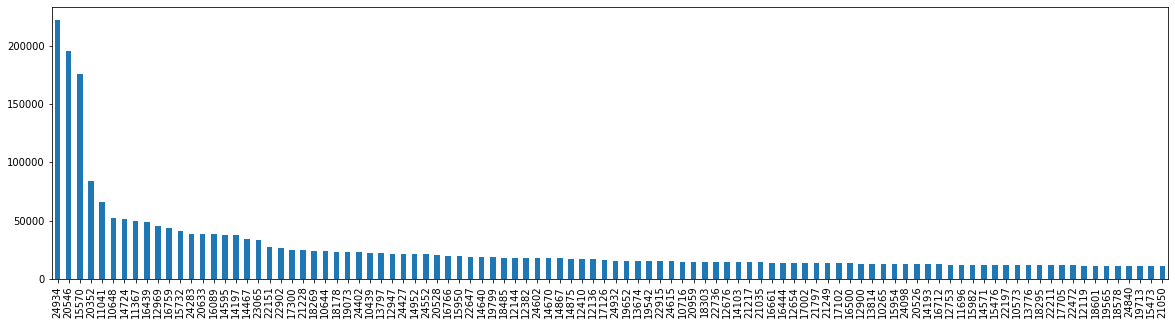

In [ ]:
#24934, 20546, 15570

plt.figure(figsize=(20,5))
train_err.user_id.value_counts()[:100].plot(kind='bar')

======================================== this user is in problem set ========================================


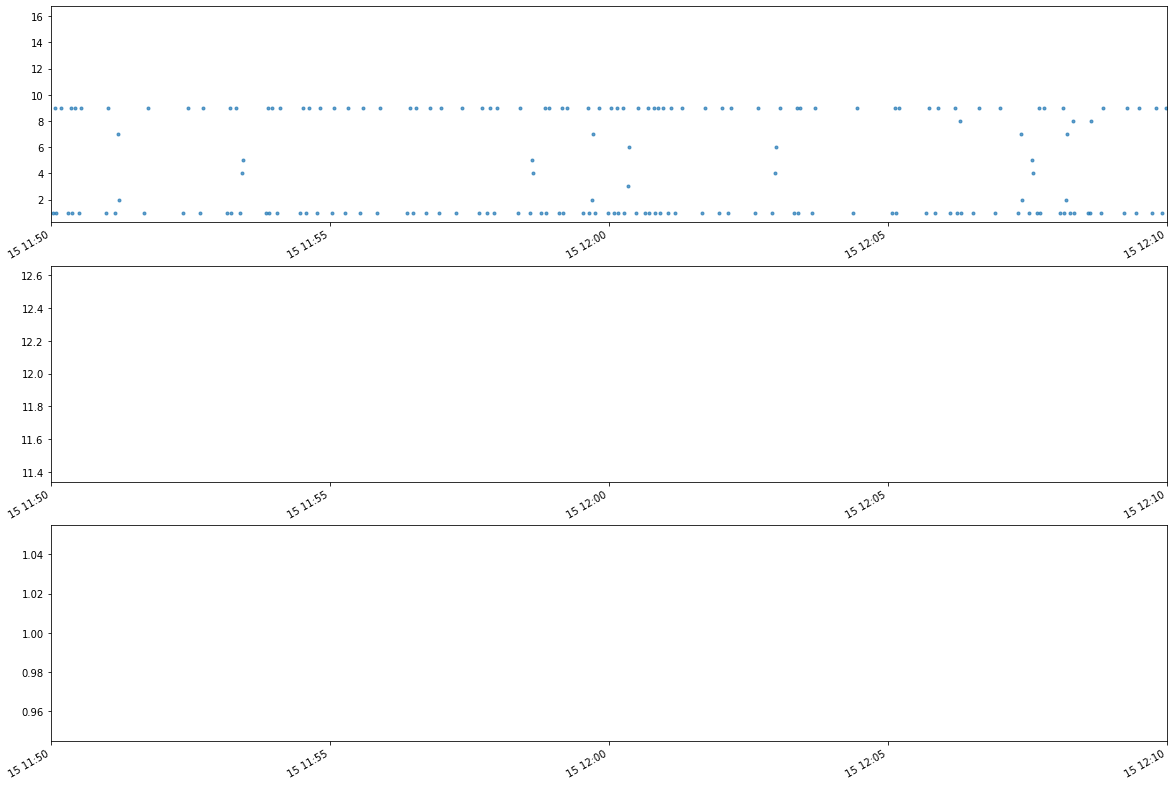

In [ ]:
# 한 시간대에 정확히 9개

train_prob_users = set(train_prob.user_id.unique())
focus_user = 15570
if focus_user in train_prob_users : print('='*40, 'this user is in problem set', '='*40)

t_start = pd.to_datetime('2020-11-15 11:50:00')
t_end = pd.to_datetime('2020-11-15 12:10:00')

plt.figure(figsize=(20,15))
plt.subplot(3, 1, 1)
train_err[train_err.user_id == focus_user].datetime.value_counts(sort=False).plot(style='.', alpha = 0.7, xlim=(t_start, t_end))
plt.subplot(3, 1, 2)
train_qual[train_qual.user_id == focus_user].datetime.value_counts(sort=False).plot(style='.', xlim=(t_start, t_end))
plt.subplot(3, 1, 3)
train_prob[train_prob.user_id == focus_user].datetime.value_counts(sort=False).plot(style='.', xlim=(t_start, t_end))

In [ ]:
train_err_by_datetime = train_err[train_err.user_id == focus_user] \
  .groupby('datetime') \
  .agg({
      'datetime' : lambda x: x.count(),
      'errtype' : [lambda x: x.value_counts().index[0], lambda x: x.value_counts().tolist()[0]]
  })

train_err_by_datetime.columns = ['counts', 'errtype', 'err_counts']
train_err_by_datetime['err_freq'] = train_err_by_datetime.err_counts / train_err_by_datetime.counts

train_err_by_datetime = train_err_by_datetime.reset_index('datetime')

display(train_err_by_datetime)

,datetime,counts,errtype,err_counts,err_freq
0,2020-11-01 04:40:21,1,1,1,1.000000
1,2020-11-01 06:35:40,1,16,1,1.000000
2,2020-11-01 06:35:43,1,4,1,1.000000
3,2020-11-01 07:01:08,1,4,1,1.000000
4,2020-11-01 07:01:11,9,28,4,0.444444
...,...,...,...,...,...
37721,2020-11-30 17:29:21,1,4,1,1.000000
37722,2020-11-30 17:29:22,1,15,1,1.000000
37723,2020-11-30 17:46:07,1,16,1,1.000000
37724,2020-11-30 17:46:11,1,4,1,1.000000


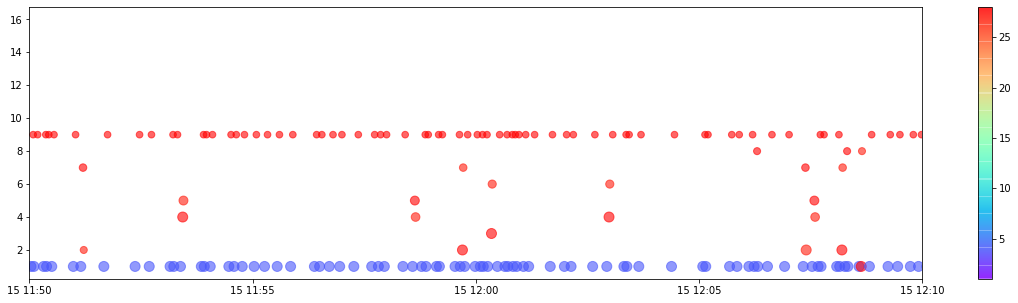

In [ ]:
plt.figure(figsize=(20,5))
plt.scatter(
    train_err_by_datetime.datetime,
    train_err_by_datetime.counts,
    s = (train_err_by_datetime.err_freq)*100,
    c = train_err_by_datetime.errtype,
    cmap = plt.cm.rainbow,
    alpha = 0.6
)
plt.xlim(t_start, t_end)
plt.colorbar()

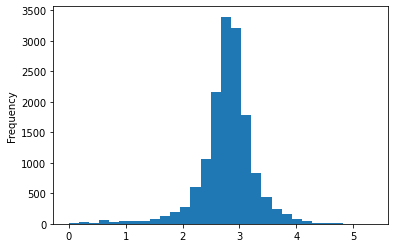

In [ ]:
# user_id 당 err 횟수의 분포. 대부분 500~1000개

train_err.user_id.value_counts().map(lambda x: np.log10(x)).sort_index().plot(kind='hist', bins=30)

In [ ]:
train_qual.user_id.value_counts().loc[lambda x: x % 12 != 0]

Series([], Name: user_id, dtype: int64)

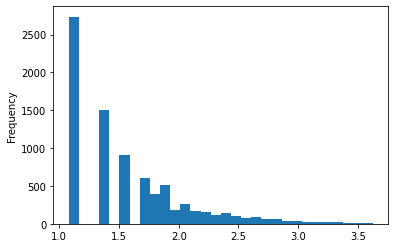

In [ ]:
# user_id 당 qual 횟수의 분포. 전부 12의 배수다.

train_qual.user_id.value_counts().map(lambda x: np.log10(x)).sort_index().plot(kind='hist', bins=30)

In [ ]:
qual_users = set(train_qual.user_id.unique())
prob_users = set(train_prob.user_id.unique())
print(len(qual_users))
print(len(prob_users))
print(len(prob_users.difference(qual_users)))
print(len(qual_users.difference(prob_users)))

8281
5000
1833
5114


#### 질문

`train_err` 에는 전원이 들어 있지만, `train_qual`은 절반 사람밖에 없다. 심지어 `train_prob` 의 5000명과 일부 겹치므로, 전부 알지 못한다.

어떡하지?

## Q5. `errorcode` 를 검색해 보자.

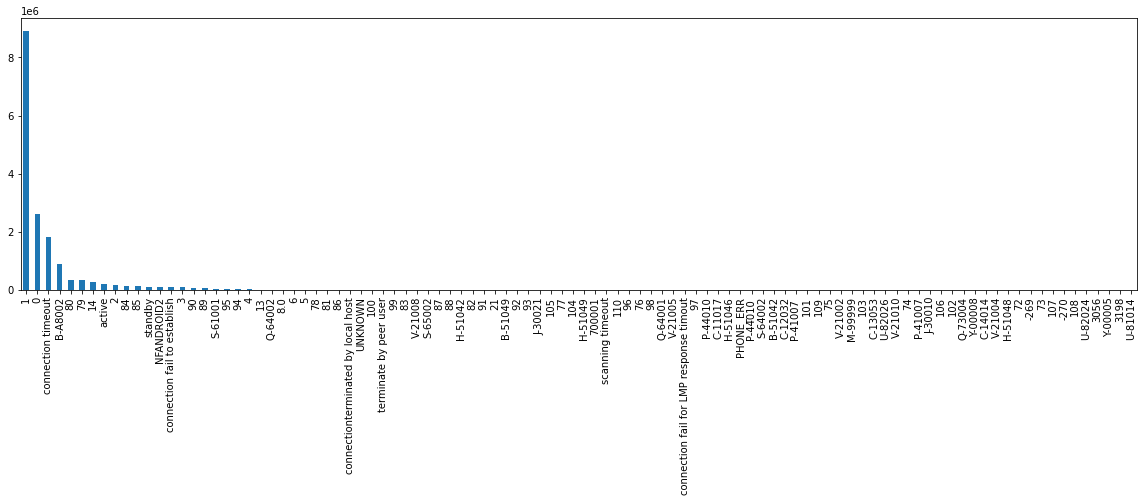

In [ ]:
plt.figure(figsize=(20,5))
train_err.errcode.value_counts()[:100].plot(kind='bar')

In [ ]:

train_err.errcode.value_counts().index.tolist()[600:800]

['3360',
 '3379',
 '3979',
 '3186',
 '5464',
 '4567',
 '5698',
 '3415',
 '5411',
 '5824',
 '3802',
 '5705',
 '5757',
 '3493',
 '4467',
 '4018',
 '5762',
 '3713',
 '3332',
 '3709',
 '3876',
 '5747',
 '5275',
 '3036',
 '3640',
 '5944',
 '3737',
 '3504',
 '4259',
 '6148',
 '9028',
 '3589',
 '16352',
 'U-82023',
 '3601',
 '5766',
 '3553',
 '5641',
 '5922',
 '3809',
 '8200',
 'U-81000',
 '5471',
 '3201',
 '6412',
 '6023',
 '5420',
 '5950',
 '3194',
 '5048',
 '3080',
 '4389',
 '3532',
 '3409',
 '4808',
 '5567',
 '5611',
 '3462',
 '3326',
 '3587',
 '5539',
 '3223',
 '5858',
 '10955',
 '3568',
 '3608',
 '3081',
 '3762',
 '3434',
 '6016',
 '5578',
 '3706',
 '4108',
 '4192',
 '7770',
 '3114',
 '3327',
 '41',
 '6711',
 '3560',
 '3305',
 '3615',
 '5783',
 '5391',
 '3174',
 '3343',
 '3481',
 '3218',
 '5870',
 '3509',
 '4045',
 '5541',
 '6013',
 '3616',
 '4195',
 '4606',
 '3925',
 '3465',
 '3396',
 '3534',
 '5022',
 '3657',
 '5911',
 '5412',
 '3544',
 '4386',
 '3321',
 '5959',
 '3163',
 '4563',
 '57

- NFANDROID : 일단 lg 붙여서 검색해보니 넷플릭스? 셋탑박스? 게임셋톱? 관련 로그파일? 이 나온다. NVDIA shield tv (게임 셋톱박스) 기기의 로그파일인듯 함. lg 빼고 검색하니까 외국 글 중에서 smart tv upgrader? 관련 문의글? 이 있었고, lg도 이런 업그레이더를 만든다고 한다(LG ST600).
- connection fail for LMP response timout : link management protocol. 블루투스 연결 30초 제한에 관련된 듯.
- L2CAP connection cancelled : logical link control and adaptation protocol. 블루투스 연결 방식? 이다. IoT랑 관련있는듯.
https://m.blog.naver.com/PostView.nhn?blogId=ksgbaek&logNo=220930190486&proxyReferer=https:%2F%2Fwww.google.com%2F

## Q6. `quality_n` 간의 연관성

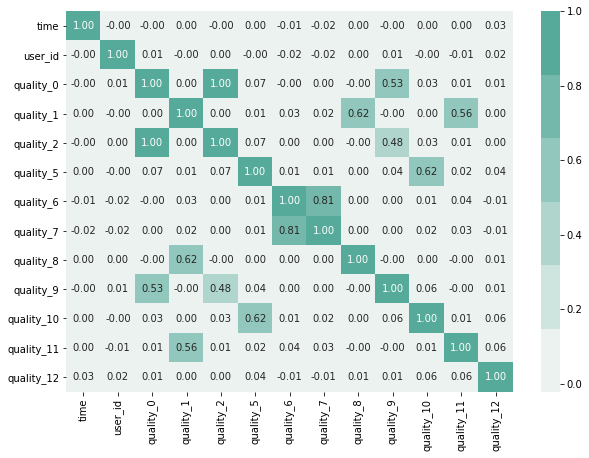

In [ ]:
# 본격적으로 

import seaborn as sns

corr = train_qual.drop(['quality_3', 'quality_4'], axis=1).corr()
f, ax = plt.subplots(figsize = (10, 7))
sns.heatmap(corr, cmap=sns.color_palette("light:#5A9"), annot=True, fmt='.2f')

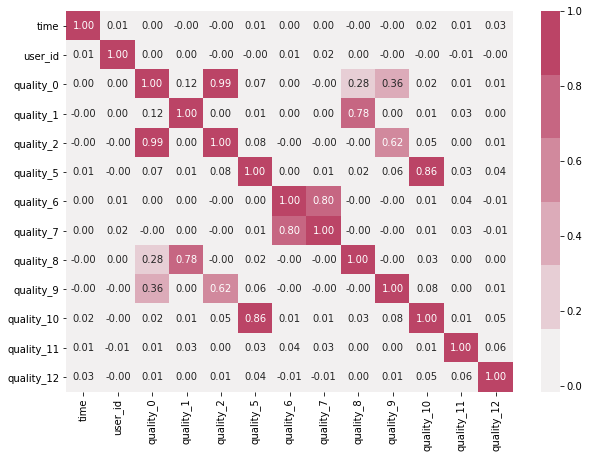

In [ ]:
corr = test_qual.drop(['quality_3', 'quality_4'], axis=1).corr()
f, ax = plt.subplots(figsize = (10, 7))
sns.heatmap(corr, cmap=sns.color_palette("light:#B46"), annot=True, fmt='.2f')

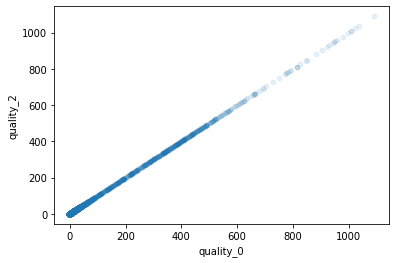

In [ ]:
# quality_0, 2 는 완전히 같았다. 2의 null이 0에 포함되니까 2를 선택하면 될까?

focus_users = train_qual.user_id.value_counts().index
focus_user = focus_users[:100]
focus_qualities = ['quality_0', 'quality_2']
train_qual[train_qual.user_id.isin(focus_user)][focus_qualities].plot(kind='scatter', x='quality_0', y='quality_2', alpha=0.1)

In [ ]:
# qual_2의 null 은 거의 다 qual_0의 null에 포함되고, qual_0이 null일 때 qual_2는 쓸모있는 값들이 많음. 좋아! 

print(train_qual.quality_2.isnull().sum(), 'NaNs in qual_2')
print('='*80)
print('When qual_0 is NaN, qual_2 is...')
print(train_qual[train_qual.quality_0.isnull()].quality_2.value_counts(dropna=False))

40113 NaNs in qual_2
When qual_0 is NaN, qual_2 is...
 0.0       89715
 NaN       40080
-1.0       13564
 1.0         538
 2.0         112
           ...  
 33.0          1
 3672.0        1
 3678.0        1
 3679.0        1
 3067.0        1
Name: quality_2, Length: 121, dtype: int64


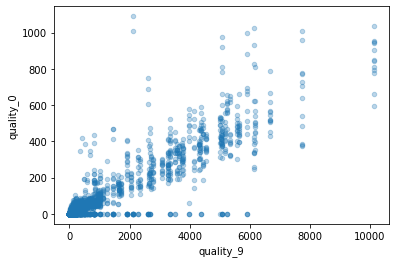

In [ ]:
# 오. qual_9도 비례가 많이 보이는데? 단, 기울기에 주의
# qual_0은 상관없이 -1일 때가 많구나.
# 전체 인원으로 찍어보면, qual_9 = 400000 부근에 수직선? 느낌 있음.

focus_qualities = ['quality_0', 'quality_9']
train_qual[train_qual.user_id.isin(focus_user)][focus_qualities].plot(kind='scatter', x='quality_9', y='quality_0', alpha=0.3)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd0c2339b70>,
      dtype=object)

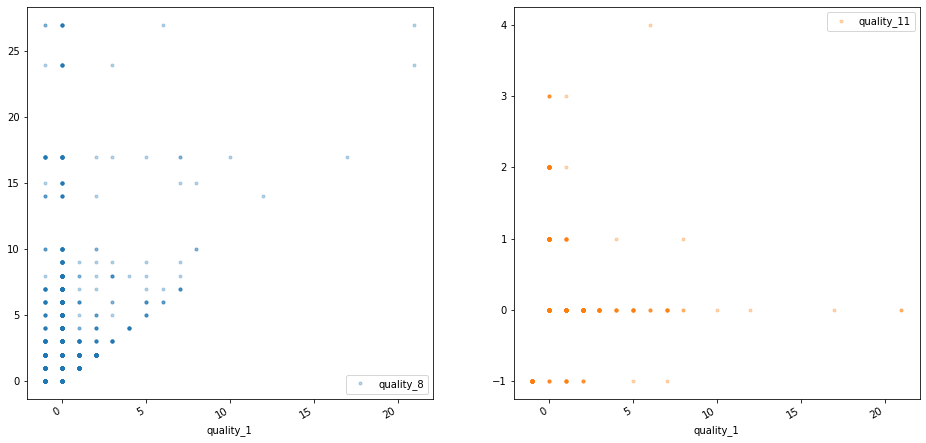

In [ ]:
# qual_8 >= qual_1 ?? 신기한 관계.
# qual_11은 거의 관계가 없다고 보는게... 다만, qual_1이 -1이면 qual_11도 -1인 것 같다.

focus_qualities = ['quality_1', 'quality_8', 'quality_11']
train_qual[train_qual.user_id.isin(focus_user)][focus_qualities].plot(style='.', x='quality_1', alpha=0.3, subplots=True, figsize=(16,8), layout=(1,2))

quality_1
-1         0
 0         0
 1         1
 2         2
 3         3
 4         4
 5         5
 6         6
 7         7
 8         8
 9         9
 10       10
 11       11
 12       13
 13       13
 14       14
 15       15
 16       25
 17       17
 18       18
 19       38
 20       20
 21       24
 23       23
 35       35
 40     1317
 88     1317
 117     125
 169    1317
 170    1317
 171    1317
Name: quality_8, dtype: int64


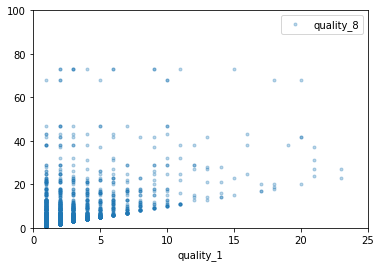

In [ ]:
# 맞네. 신기... 뭐하는 친구들이지
train_qual[train_qual.quality_1 > 0][['quality_1', 'quality_8']].plot(style='.', x='quality_1', alpha=0.3, xlim=(0,25), ylim=(0,100))

print(train_qual.groupby('quality_1').quality_8.min())

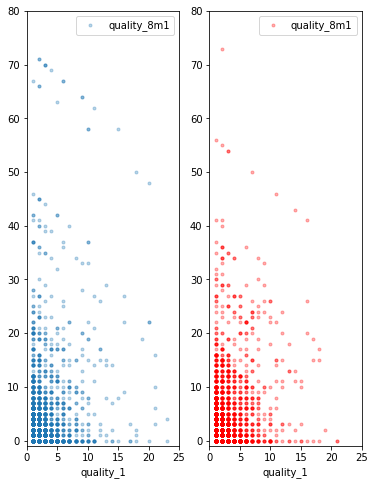

In [ ]:
# 이건 아닌것같다. 오히려 사선이 많아짐.
fig, axes = plt.subplots(1, 2, figsize=(15,8))

train_qual['quality_8m1'] = train_qual.quality_8 - train_qual.quality_1
test_qual['quality_8m1'] = test_qual.quality_8 - test_qual.quality_1
train_qual[train_qual.quality_1 > 0][['quality_1', 'quality_8m1']].plot(ax=axes[0], style='.', x='quality_1', alpha=0.3, xlim=(0,25), ylim=(-1,80), figsize=(6,8))
test_qual[test_qual.quality_1 > 0][['quality_1', 'quality_8m1']].plot(ax=axes[1], color='red', style='.', x='quality_1', alpha=0.3, xlim=(0,25), ylim=(-1,80), figsize=(6,8))

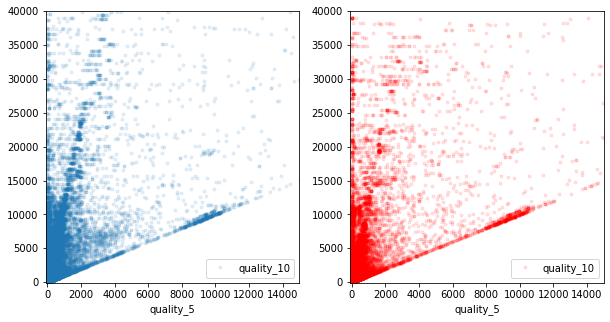

In [ ]:
# qual_10 >= qual_5
# 이 두 값은 서로 대체할 수 있지 않을까?
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

focus_qualities = ['quality_5', 'quality_10']
train_qual[train_qual.quality_5 > 0][focus_qualities].plot(ax=ax1, style='.', x='quality_5', alpha=0.1, xlim=(-100,15000), ylim=(-100,40000))
test_qual[test_qual.quality_5 > 0][focus_qualities].plot(ax=ax2, color='red', style='.', x='quality_5', alpha=0.1, xlim=(-100,15000), ylim=(-100,40000))

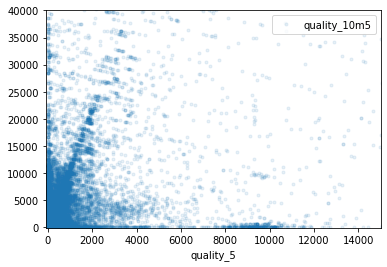

In [ ]:
train_qual['quality_10m5'] = train_qual.quality_10 - train_qual.quality_5
train_qual[train_qual.quality_5 > 0][['quality_5', 'quality_10m5']].plot(style='.', x='quality_5', alpha=0.1, xlim=(-100,15000), ylim=(-100,40000))

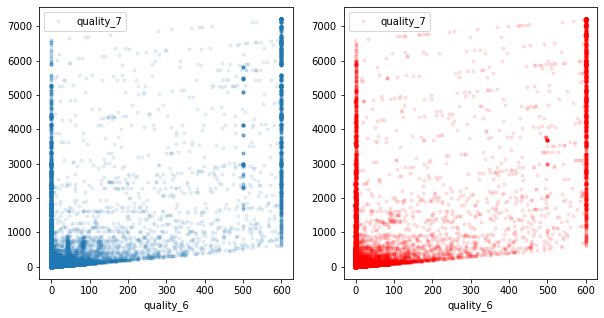

In [ ]:
# qual_7 >= qual_6
# qual_6의 재밌는 패턴
fig, axes = plt.subplots(1, 2, figsize=(10,5))

focus_qualities = ['quality_6', 'quality_7']
train_qual[focus_qualities].plot(ax=axes[0], style='.', x='quality_6', alpha=0.1)#, xlim=(-10,500), ylim=(-10,1000))
test_qual[focus_qualities].plot(ax=axes[1], color='red', style='.', x='quality_6', alpha=0.1)#, xlim=(-10,500), ylim=(-10,1000))

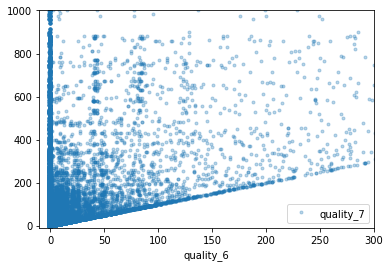

In [ ]:
# 확대

focus_qualities = ['quality_6', 'quality_7']
train_qual[focus_qualities].plot(style='.', x='quality_6', alpha=0.3, xlim=(-10,300), ylim=(-10,1000))

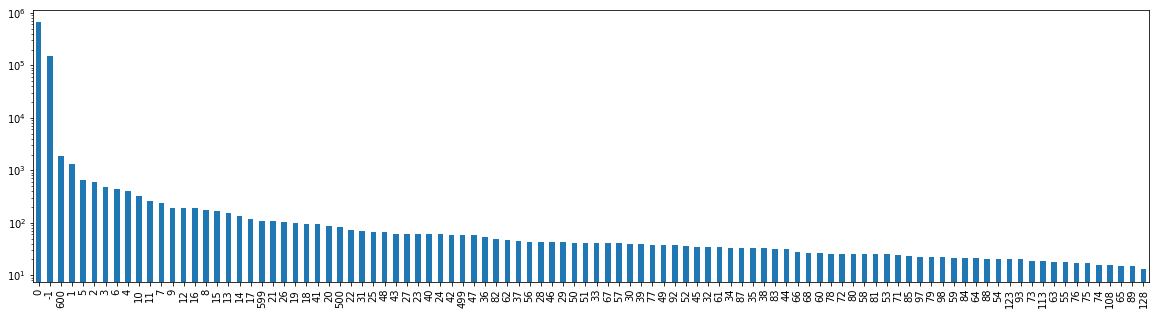

In [ ]:
# qual_6 의 세로줄은 뭐지?

train_qual.quality_6.value_counts()[:100].plot(kind='bar', figsize=(20,5), logy=True)

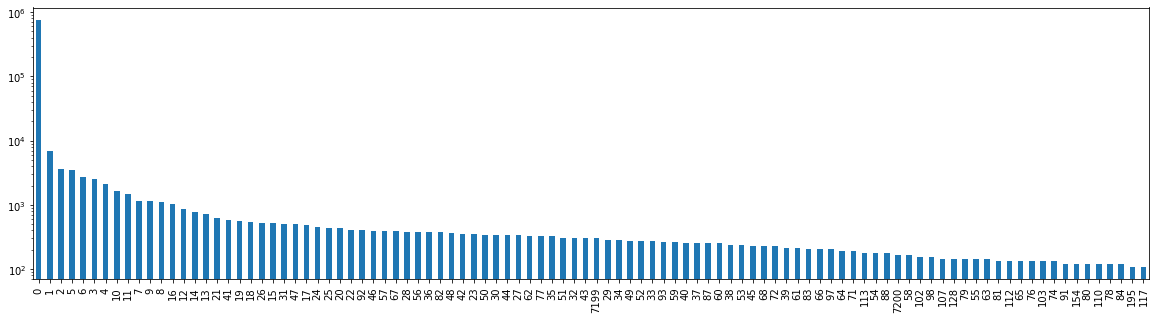

In [ ]:
train_qual.quality_7.value_counts()[:100].plot(kind='bar', figsize=(20,5), logy=True)

## Q7. `model_nm` 의 의미

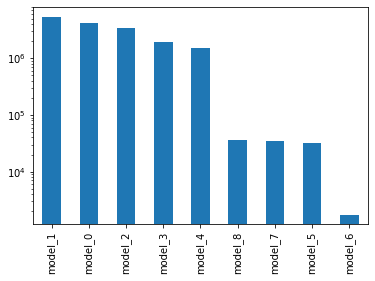

In [ ]:
train_err.model_nm.value_counts().plot(kind='bar', logy=True)

In [ ]:
# model별로 fwver가 분리될까?

train_err.groupby(['model_nm']).fwver.value_counts()

model_nm  fwver     
model_0   04.22.1750    2874207
          04.22.1778    1293934
          04.22.1684       5554
          04.22.1442       2522
          04.22.1656         39
          04.22.1666          5
model_1   04.16.3553    5237795
          04.16.3571     145156
          04.16.3569        980
          04.16.2641        296
          04.16.3439        142
          04.16.3345        101
model_2   04.33.1261    2504849
          04.33.1185     963732
          04.33.1149       3272
          04.33.1095        909
          04.33.1125        408
          04.33.1171         58
model_3   05.15.2138    1906469
          05.15.2120        706
          05.15.3104        191
          05.15.2122         23
          05.15.2092         18
          05.15.2090         12
          05.15.2114          9
model_4   03.11.1167    1505652
          03.11.1149       2114
          03.11.1141         29
model_5   04.82.1684      23554
          04.82.1778       8601
          04.82.173

In [ ]:
(train_err[train_err.model_nm == 'model_0']
  .groupby(['fwver', 'errtype'])
  .size()
  .reset_index()
  .groupby('fwver')
  .apply(lambda x: x.nlargest(10, 0))).head(60)

fwver  errtype       0
fwver                                      
04.22.1442 14   04.22.1442       23     696
           13   04.22.1442       22     658
           0    04.22.1442        4     486
           9    04.22.1442       15     286
           10   04.22.1442       16     173
           6    04.22.1442       12      66
           5    04.22.1442       11      59
           16   04.22.1442       26      52
           7    04.22.1442       13      10
           8    04.22.1442       14      10
04.22.1656 19   04.22.1656        6       5
           20   04.22.1656        7       5
           24   04.22.1656       14       5
           17   04.22.1656        4       4
           23   04.22.1656       13       3
           25   04.22.1656       15       3
           28   04.22.1656       23       3
           22   04.22.1656       12       2
           26   04.22.1656       16       2
           27   04.22.1656       22       2
04.22.1666 34   04.22.1666       14       2
           32   04.22.1666       12       1
           33   04.22.1666       13       1
           35   04.22.1666       38       1
04.22.1684 57   04.22.1684       31    2930
           38   04.22.1684        5    1321
           45   04.22.1684       14     291
           62   04.22.1684       40     273
           46   04.22.1684       15     139
           47   04.22.1684       16     134
           61   04.22.1684       38     131
           59   04.22.1684       34      54
           63   04.22.1684       41      31
           43   04.22.1684       12      29
04.22.1750 92   04.22.1750       31  510162
           84   04.22.1750       22  418553
           85   04.22.1750       23  406403
           77   04.22.1750       15  378368
           67   04.22.1750        5  279747
           78   04.22.1750       16  273166
           101  04.22.1750       40  173898
           88   04.22.1750       26   83820
           74   04.22.1750       12   60456
           73   04.22.1750       11   58650
04.22.1778 132  04.22.1778       31  223930
           124  04.22.1778       22  197832
           125  04.22.1778       23  167060
           117  04.22.1778       15  167034
           118  04.22.1778       16  120600
           107  04.22.1778        5  114488
           128  04.22.1778       26   74159
           141  04.22.1778       40   69049
           114  04.22.1778       12   27179
           113  04.22.1778       11   26498

In [ ]:
(train_err[train_err.model_nm == 'model_1']
  .groupby(['fwver', 'errtype'])
  .size().reset_index()
  .groupby('fwver')
  .apply(lambda x: x.nlargest(10, 0)))

fwver  errtype        0
fwver                                       
04.16.2641 1    04.16.2641        4       81
           8    04.16.2641       15       53
           9    04.16.2641       16       52
           12   04.16.2641       26       28
           10   04.16.2641       22       24
           5    04.16.2641       12       20
           4    04.16.2641       11       19
           7    04.16.2641       14        7
           3    04.16.2641        7        5
           11   04.16.2641       23        3
04.16.3345 14   04.16.3345        4       43
           19   04.16.3345       15       14
           20   04.16.3345       16       10
           16   04.16.3345       11        9
           17   04.16.3345       12        9
           21   04.16.3345       26        9
           15   04.16.3345       10        3
           13   04.16.3345        3        2
           18   04.16.3345       14        2
04.16.3439 30   04.16.3439       23       37
           34   04.16.3439       31       32
           29   04.16.3439       22       31
           28   04.16.3439       16        7
           35   04.16.3439       33        7
           26   04.16.3439       14        5
           39   04.16.3439       40        4
           22   04.16.3439        6        2
           23   04.16.3439        7        2
           24   04.16.3439       11        2
04.16.3553 61   04.16.3553       23  1468294
           69   04.16.3553       32  1073268
           60   04.16.3553       22   970609
           68   04.16.3553       31   506653
           53   04.16.3553       15   264147
           43   04.16.3553        5   215494
           54   04.16.3553       16   212222
           77   04.16.3553       40   116527
           64   04.16.3553       26    74951
           50   04.16.3553       12    57994
04.16.3569 88   04.16.3569       23      324
           87   04.16.3569       22      273
           91   04.16.3569       32      199
           90   04.16.3569       31       70
           84   04.16.3569       15       36
           85   04.16.3569       16       32
           89   04.16.3569       26       16
           93   04.16.3569       34        9
           82   04.16.3569       11        5
           83   04.16.3569       12        5
04.16.3571 120  04.16.3571       32    37367
           111  04.16.3571       22    22716
           112  04.16.3571       23    22251
           119  04.16.3571       31    14550
           122  04.16.3571       34    11193
           104  04.16.3571       15     8085
           105  04.16.3571       16     6319
           96   04.16.3571        5     5049
           115  04.16.3571       26     3960
           128  04.16.3571       40     3868

In [ ]:
train_prob.head()

,user_id,time,datetime
0,19224,20201102200000,2020-11-02 20:00:00
1,23664,20201116140000,2020-11-16 14:00:00
2,15166,20201114130000,2020-11-14 13:00:00
3,12590,20201108210000,2020-11-08 21:00:00
4,15932,20201103210000,2020-11-03 21:00:00


In [ ]:
def count_list(x, li) :
  count = 0
  for p in x :
    if p in li : count += 1
  return count

probs_by_models = (train_err.groupby(['model_nm', 'fwver'])
  .apply(lambda x: x.user_id.unique())
  .apply(lambda x: count_list(x, prob_users)))

print(probs_by_models)
print(probs_by_models.sum())

model_nm  fwver     
model_0   04.22.1442       1
          04.22.1656       1
          04.22.1666       0
          04.22.1684      28
          04.22.1750    1630
          04.22.1778    1586
model_1   04.16.2641       1
          04.16.3345       1
          04.16.3439       2
          04.16.3553    1314
          04.16.3569       2
          04.16.3571     295
model_2   04.33.1095       0
          04.33.1125       4
          04.33.1149     112
          04.33.1171       1
          04.33.1185    1128
          04.33.1261    1739
model_3   05.15.2090       0
          05.15.2092       1
          05.15.2114       0
          05.15.2120       2
          05.15.2122       0
          05.15.2138     720
          05.15.3104       1
model_4   03.11.1141       1
          03.11.1149       0
          03.11.1167     141
model_5   04.82.1684      19
          04.82.1730       1
          04.82.1778      20
model_6   10               9
          8.5.3            0
model_7   05.66.3237  

## Q8. Distinctive features of problematic users

In [ ]:
prob_users = set(train_prob.user_id.unique())
train_qual['prob'] = train_qual.user_id.isin(prob_users)
train_qual.head()

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12,datetime,prob
0,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0.0,0,0,0,0,4,0,0,2020-11-29 09:00:00,False
1,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0.0,0,0,0,0,4,0,0,2020-11-29 09:00:00,False
2,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0.0,0,0,0,0,4,0,0,2020-11-29 09:00:00,False
3,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0.0,0,0,0,0,4,0,0,2020-11-29 09:00:00,False
4,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0.0,0,0,0,0,4,0,0,2020-11-29 09:00:00,False


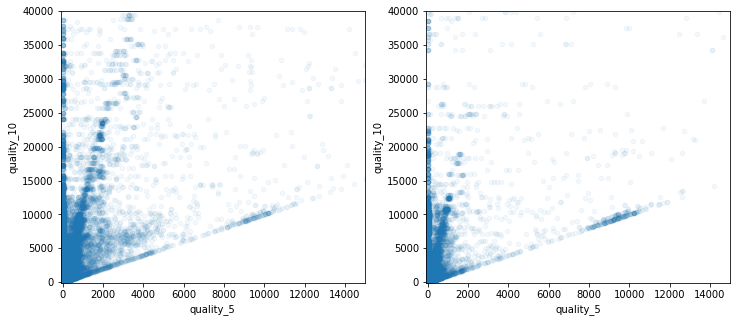

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

(train_qual[train_qual.prob & (train_qual.quality_5 > -1)]
  .plot.scatter(ax = ax1, x='quality_5', y='quality_10', alpha=0.05, xlim=(-100, 15000), ylim=(-100, 40000)))
(train_qual[~train_qual.prob & (train_qual.quality_5 > -1)]
  .plot.scatter(ax = ax2, x='quality_5', y='quality_10', alpha=0.05, xlim=(-100, 15000), ylim=(-100, 40000)))

left has 2.8346746692129314 times more points than right


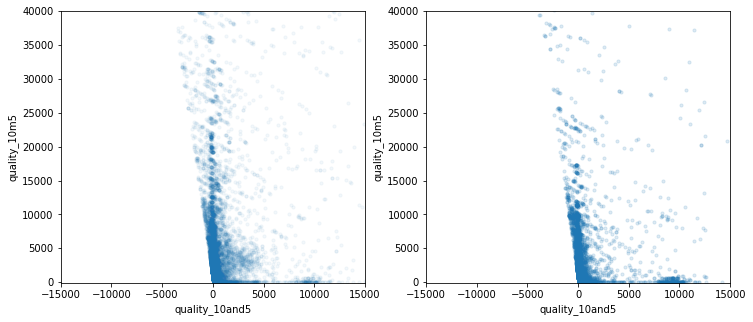

In [ ]:
a = train_qual[train_qual.prob & (train_qual.quality_5 > 100)].size
b = train_qual[~train_qual.prob & (train_qual.quality_5 > 100)].size
print(f'left has {a / b} times more points than right')

train_qual['quality_10m5'] = train_qual.quality_10 - train_qual.quality_5
train_qual['quality_10and5'] = train_qual.quality_5 - 0.1 * train_qual.quality_10m5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

(train_qual[train_qual.prob & (train_qual.quality_5 > 100)]
  .plot.scatter(ax = ax1, x='quality_10and5', y='quality_10m5', alpha=0.05, s=10, xlim=(-15000, 15000), ylim=(-100, 40000)))
(train_qual[~train_qual.prob & (train_qual.quality_5 > 100)]
  .plot.scatter(ax = ax2, x='quality_10and5', y='quality_10m5', alpha=0.14, s=10, xlim=(-15000, 15000), ylim=(-100, 40000)))

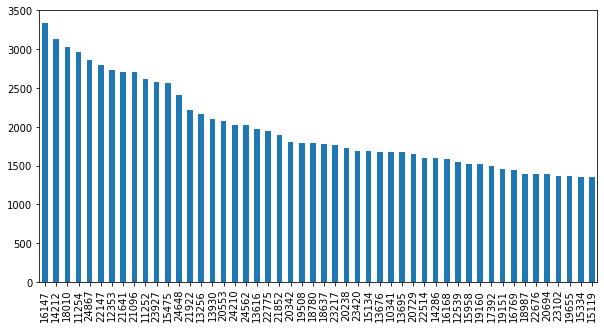

In [ ]:
qual_prob_count = train_qual[train_qual.user_id.isin(prob_users)].user_id.value_counts()
qual_notprob_count = train_qual[~train_qual.user_id.isin(prob_users)].user_id.value_counts()
qual_prob_count[:50].plot(kind='bar', figsize=(10,5))

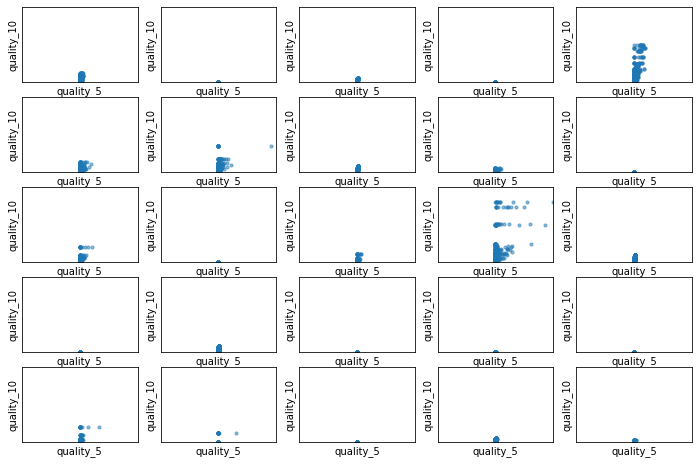

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(12,8))
plt.setp(axes, xticks=[], yticks=[], xlabel='', ylabel='', )
i = 50
for rax in axes :
  for cax in rax :
    (train_qual[(train_qual.user_id == qual_prob_count.index[i])]
      .plot.scatter(ax = cax, x='quality_5', y='quality_10', alpha=0.5, s=10, xlim=(-15000, 15000), ylim=(-100, 40000)))
    i += 1

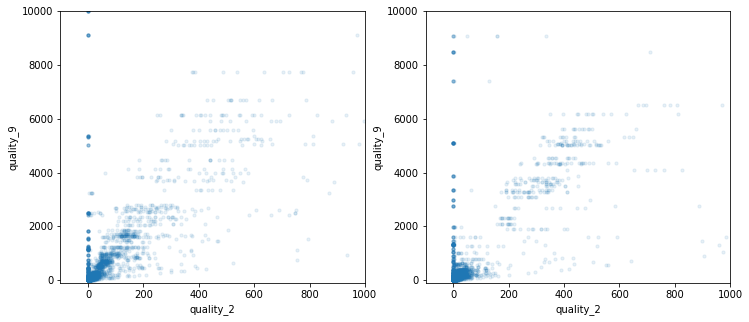

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

(train_qual[train_qual.prob & (train_qual.quality_2 > -1)]
  .plot.scatter(ax = ax1, x='quality_2', y='quality_9', alpha=0.1, s=10, xlim=(-100, 1000), ylim=(-100, 10000)))
(train_qual[~train_qual.prob & (train_qual.quality_2 > -1)]
  .plot.scatter(ax = ax2, x='quality_2', y='quality_9', alpha=0.1, s=10, xlim=(-100, 1000), ylim=(-100, 10000)))

left has 0.9934976043805612 times more points than right


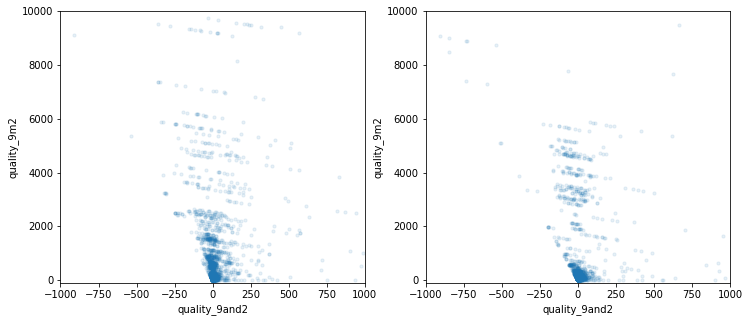

In [ ]:
a = train_qual[train_qual.prob & (train_qual.quality_2 > 0)].size
b = train_qual[~train_qual.prob & (train_qual.quality_2 > 0)].size
print(f'left has {a / b} times more points than right')

train_qual['quality_9m2'] = train_qual.quality_9 - train_qual.quality_2
train_qual['quality_9and2'] = train_qual.quality_2 - 0.1 * train_qual.quality_9m2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

(train_qual[train_qual.prob & (train_qual.quality_2 > 0)]
  .plot.scatter(ax = ax1, x='quality_9and2', y='quality_9m2', alpha=0.1, s=10, xlim=(-1000, 1000), ylim=(-100, 10000)))
(train_qual[~train_qual.prob & (train_qual.quality_2 > 0)]
  .plot.scatter(ax = ax2, x='quality_9and2', y='quality_9m2', alpha=0.1, s=10, xlim=(-1000, 1000), ylim=(-100, 10000)))

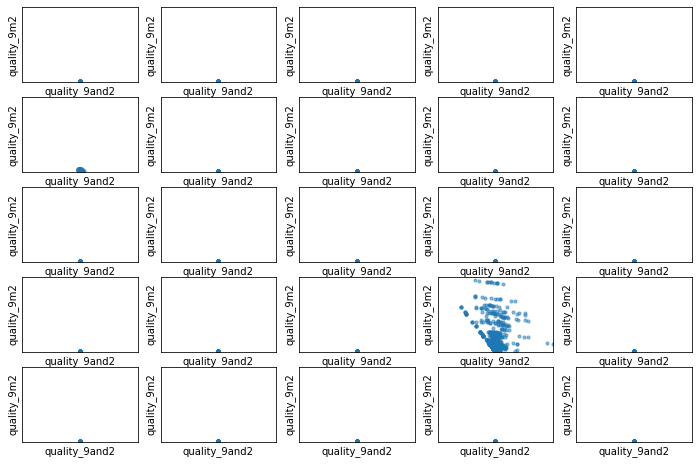

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(12,8))
plt.setp(axes, xticks=[], yticks=[])
i = 0
for rax in axes :
  for cax in rax :
    (train_qual[(train_qual.user_id == qual_prob_count.index[i])]
      .plot.scatter(ax = cax, x='quality_9and2', y='quality_9m2', alpha=0.5, s=10, xlim=(-1000, 1000), ylim=(-100, 10000)))
    i += 1

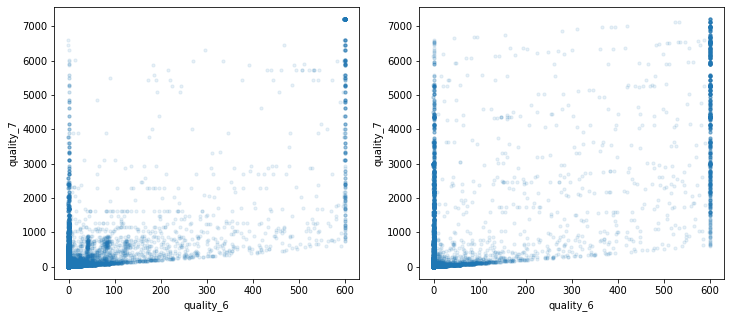

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

(train_qual[train_qual.prob & (train_qual.quality_0 > -10)]
  .plot.scatter(ax = ax1, x='quality_6', y='quality_7', alpha=0.1, s=10))
(train_qual[~train_qual.prob & (train_qual.quality_0 > -10)]
  .plot.scatter(ax = ax2, x='quality_6', y='quality_7', alpha=0.1, s=10))

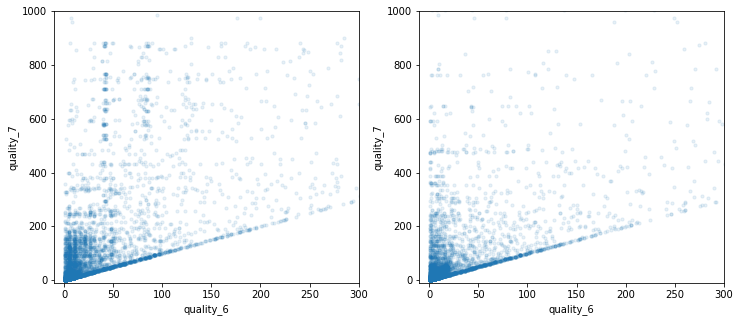

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

(train_qual[train_qual.prob & (train_qual.quality_6 > 0)]
  .plot.scatter(ax = ax1, x='quality_6', y='quality_7', alpha=0.1, s=10, xlim=(-10,300), ylim=(-10,1000)))
(train_qual[~train_qual.prob & (train_qual.quality_6 > 0)]
  .plot.scatter(ax = ax2, x='quality_6', y='quality_7', alpha=0.1, s=10, xlim=(-10,300), ylim=(-10,1000)))

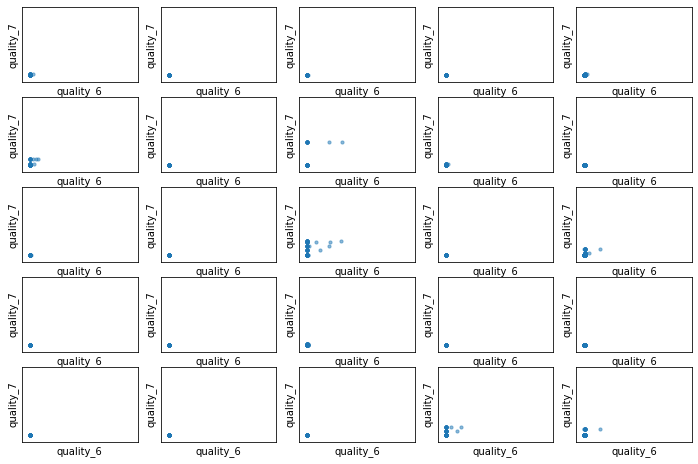

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(12,8))
plt.setp(axes, xticks=[], yticks=[])
i = 0
for rax in axes :
  for cax in rax :
    (train_qual[(train_qual.user_id == qual_prob_count.index[i])]
      .plot.scatter(ax = cax, x='quality_6', y='quality_7', alpha=0.5, s=10, xlim=(-50, 650), ylim=(-100, 1000)))
    i += 1

어떻게 해야 할까..
- `qual` 의 행동이 `prob`에 따라 조오오오금 되긴 하지만... 이전에 한 방식대로(최빈값) 요약하는 과정에서 다 사라질 것 같다.
- 넓이를 구해볼까? 그러면 변동이 너무 클거같은데...